# Interactias

The impact that invasive species have on other biodiversity is largely to do with the interactions the invasive species has on the local species. Invasive species can predate or parasitize, they can disrupte pollination networks, they can compete with local species for different resources and many other types of interaction.

Nevertheless, while much of the research on IAS is related to modelling spread and distribution, interactions are not as easy to study. Species interactions can happen very quickly, but have large consequences for the actors e.g. predation. They can happen only rarely, or a certain times of the day or season. Interactions are also difficult to quantify with relation to the impact on the interacting organisms.

The aim of this notebook is to try to quantify the actual or potential impact of an invasive species through our knowledge of its interactions and the abundance of its actors.

I will harvest species interactions data from GLOBI (https://www.globalbioticinteractions.org/) to discover the species that interact with an invasive species. I will then compare these interactions with the occupancy of the interacting species in a particular area.

This notebook takes considerable insperation and code from Yikang Li's project on GLoBI (https://curiositydata.org/part1_globi_access/).

In [1]:
import pandas as pd
#import pytaxize
import re
import matplotlib.pyplot as plt

## Load the GLoBI data

The current snapshot of GLoBI was taken on 2019-11-05 from https://depot.globalbioticinteractions.org/snapshot/target/data/tsv/interactions.tsv.gz


In [2]:
# This takes a few minutes to load in.
# the low_memory=False property will get rid of a warning, but will not help if there is really no memory left
data = pd.read_csv('C://Users//quentin//Documents//interactias//interactias//data//interactions.tsv', delimiter='\t', encoding='utf-8', low_memory=False)
len(data)

3878740

In [3]:
# Take a little look at the data to make sure it makes sense
data.head()

,sourceTaxonId,sourceTaxonIds,sourceTaxonName,sourceTaxonRank,sourceTaxonPathNames,sourceTaxonPathIds,sourceTaxonPathRankNames,sourceTaxonSpeciesName,sourceTaxonSpeciesId,sourceTaxonGenusName,...,eventDateUnixEpoch,argumentTypeId,referenceCitation,referenceDoi,referenceUrl,sourceCitation,sourceNamespace,sourceArchiveURI,sourceDOI,sourceLastSeenAtUnixEpoch
0,EOL:12001247,EOL:12001247 | OTT:133330 | IRMNG:11733708 | N...,Leptoconchus massini,species,Animalia | Mollusca | Gastropoda | Neogastropo...,EOL:1 | EOL:2195 | EOL:2366 | EOL:2447 | EOL:4...,kingdom | phylum | class | order | superfamily...,Leptoconchus massini,EOL:12001247,Leptoconchus,...,NaN,https://en.wiktionary.org/wiki/support,"Gittenberger, A., Gittenberger, E. (2011). Cry...",10.1007/s13127-011-0039-1,NaN,Jorrit H. Poelen. 2014. Species associations m...,FloraVincent/template-dataset,https://github.com/FloraVincent/template-datas...,NaN,2019-03-30T23:08:44.205Z
1,EOL:12001247,EOL:12001247 | OTT:133330 | IRMNG:11733708 | N...,Leptoconchus massini,species,Animalia | Mollusca | Gastropoda | Neogastropo...,EOL:1 | EOL:2195 | EOL:2366 | EOL:2447 | EOL:4...,kingdom | phylum | class | order | superfamily...,Leptoconchus massini,EOL:12001247,Leptoconchus,...,NaN,https://en.wiktionary.org/wiki/support,"Gittenberger, A., Gittenberger, E. (2011). Cry...",10.1007/s13127-011-0039-1,NaN,Jorrit H. Poelen. 2014. Species associations m...,FloraVincent/template-dataset,https://github.com/FloraVincent/template-datas...,NaN,2019-03-30T23:08:44.205Z
2,EOL:12001243,EOL:12001243 | WD:Q13393577 | OTT:550603 | WOR...,Leptoconchus inpleuractis,species,Animalia | Mollusca | Gastropoda | Neogastropo...,EOL:1 | EOL:2195 | EOL:2366 | EOL:2447 | EOL:4...,kingdom | phylum | class | order | superfamily...,Leptoconchus inpleuractis,EOL:12001243,Leptoconchus,...,NaN,https://en.wiktionary.org/wiki/support,"Gittenberger, A., Gittenberger, E. (2011). Cry...",10.1007/s13127-011-0039-1,NaN,Jorrit H. Poelen. 2014. Species associations m...,FloraVincent/template-dataset,https://github.com/FloraVincent/template-datas...,NaN,2019-03-30T23:08:44.205Z
3,EOL:12001243,EOL:12001243 | WD:Q13393577 | OTT:550603 | WOR...,Leptoconchus inpleuractis,species,Animalia | Mollusca | Gastropoda | Neogastropo...,EOL:1 | EOL:2195 | EOL:2366 | EOL:2447 | EOL:4...,kingdom | phylum | class | order | superfamily...,Leptoconchus inpleuractis,EOL:12001243,Leptoconchus,...,NaN,https://en.wiktionary.org/wiki/support,"Gittenberger, A., Gittenberger, E. (2011). Cry...",10.1007/s13127-011-0039-1,NaN,Jorrit H. Poelen. 2014. Species associations m...,FloraVincent/template-dataset,https://github.com/FloraVincent/template-datas...,NaN,2019-03-30T23:08:44.205Z
4,EOL:12001243,EOL:12001243 | WD:Q13393577 | OTT:550603 | WOR...,Leptoconchus inpleuractis,species,Animalia | Mollusca | Gastropoda | Neogastropo...,EOL:1 | EOL:2195 | EOL:2366 | EOL:2447 | EOL:4...,kingdom | phylum | class | order | superfamily...,Leptoconchus inpleuractis,EOL:12001243,Leptoconchus,...,NaN,https://en.wiktionary.org/wiki/support,"Gittenberger, A., Gittenberger, E. (2011). Cry...",10.1007/s13127-011-0039-1,NaN,Jorrit H. Poelen. 2014. Species associations m...,FloraVincent/template-dataset,https://github.com/FloraVincent/template-datas...,NaN,2019-03-30T23:08:44.205Z


In [4]:
# List all the interaction types
data['interactionTypeName'].unique()

array(['parasiteOf', 'symbiontOf', 'commensalistOf', 'mutualistOf',
       'eats', 'interactsWith', 'hasHost', 'pathogenOf', 'preysOn',
       'pollinates', 'coOccursWith', 'visitsFlowersOf', 'adjacentTo',
       'dispersalVectorOf', 'endoparasitoidOf', 'endoparasiteOf',
       'hasVector', 'ectoParasiteOf', 'livesOn', 'livesNear',
       'parasitoidOf', 'guestOf', 'livesInsideOf', 'farms',
       'ectoParasitoid', 'inhabits', 'kills', 'hasDispersalVector',
       'livesUnder', 'kleptoparasiteOf', 'laysEggsOn', 'visits',
       'ecologicallyRelatedTo'], dtype=object)

## Drop duplicates

This line gets rid of duplicate interations. I currently can't see a reason to keep them, but this perhaps should be checked. 
Some more common interactions might have more support in the literature and therefore more records. Deduplicating them tends to equal out rare interactions with common ones.

In [5]:
data.drop_duplicates(['sourceTaxonId', 'interactionTypeName', 'targetTaxonId'], inplace = True)

In [6]:
## Chech how mant rows are left
len(data)

1101736

Define the key taxon for the notebook for which to find all interactions


In [82]:
taxon = "Oxalis pes-caprae"
#taxon = "Lantana camara"
#taxon = "Cirsium vulgare"

In [83]:
# What are all the types of interactions involving Oxalis pes-caprae as source taxon?
data[data['sourceTaxonName'] == taxon]['interactionTypeName'].unique()

array(['interactsWith', 'pollinates'], dtype=object)

In [84]:
# What are all the types of interactions involving Oxalis pes-caprae as target taxon?
data[data['targetTaxonName'] == taxon]['interactionTypeName'].unique()

array(['visitsFlowersOf', 'hasHost', 'pollinates', 'eats',
       'interactsWith', 'parasiteOf'], dtype=object)

How many taxon sources do I have?

In [85]:
len(data[data['sourceTaxonName'] == taxon])

5

How many taxon targets do I have?

In [86]:
len(data[data['targetTaxonName'] == taxon])

40

Gather together all the data where the target is the taxon in question.

In [87]:
interacts_data = data[(data['targetTaxonName'] == taxon)]

In [88]:
interacts_data.head()

,sourceTaxonId,sourceTaxonIds,sourceTaxonName,sourceTaxonRank,sourceTaxonPathNames,sourceTaxonPathIds,sourceTaxonPathRankNames,sourceTaxonSpeciesName,sourceTaxonSpeciesId,sourceTaxonGenusName,...,eventDateUnixEpoch,argumentTypeId,referenceCitation,referenceDoi,referenceUrl,sourceCitation,sourceNamespace,sourceArchiveURI,sourceDOI,sourceLastSeenAtUnixEpoch
639342,GBIF:1345715,GBIF:1345715 | GBIF:1345715 | ITIS:753732 | OT...,Rediviva rufipes,species,Animalia | Arthropoda | Insecta | Hymenoptera ...,GBIF:1 | GBIF:54 | GBIF:216 | GBIF:1457 | GBIF...,kingdom | phylum | class | order | superfamily...,Rediviva rufipes,GBIF:1345715,Rediviva,...,NaN,https://en.wiktionary.org/wiki/support,"Eardley, C.D. and M. Kuhlmann. 2006. Southern ...",NaN,NaN,"Eardley C, Coetzer W. 2011. Catalogue of Afrot...",globalbioticinteractions/Catalogue-of-Afrotrop...,https://zenodo.org/record/229519/files/globalb...,10.5281/zenodo.229519,2019-11-02T23:06:27.432Z
639360,GBIF:1345725,GBIF:1345725 | OTT:4532653 | WD:Q2002744 | GBI...,Rediviva peringueyi,species,Animalia | Arthropoda | Insecta | Hymenoptera ...,GBIF:1 | GBIF:54 | GBIF:216 | GBIF:1457 | GBIF...,kingdom | phylum | class | order | superfamily...,Rediviva peringueyi,GBIF:1345725,Rediviva,...,NaN,https://en.wiktionary.org/wiki/support,"Cockerell, T.D.A. 1931. LI. Some African bees....",NaN,NaN,"Eardley C, Coetzer W. 2011. Catalogue of Afrot...",globalbioticinteractions/Catalogue-of-Afrotrop...,https://zenodo.org/record/229519/files/globalb...,10.5281/zenodo.229519,2019-11-02T23:06:27.432Z
639463,GBIF:1345733,GBIF:1345733 | GBIF:1345733 | ITIS:753729 | OT...,Rediviva parva,species,Animalia | Arthropoda | Insecta | Hymenoptera ...,GBIF:1 | GBIF:54 | GBIF:216 | GBIF:1457 | GBIF...,kingdom | phylum | class | order | superfamily...,Rediviva parva,GBIF:1345733,Rediviva,...,NaN,https://en.wiktionary.org/wiki/support,"Whitehead, V.B. and K.E. Steiner. 2001. Oil-co...",NaN,NaN,"Eardley C, Coetzer W. 2011. Catalogue of Afrot...",globalbioticinteractions/Catalogue-of-Afrotrop...,https://zenodo.org/record/229519/files/globalb...,10.5281/zenodo.229519,2019-11-02T23:06:27.432Z
639502,GBIF:1345714,GBIF:1345714 | ITIS:753725 | OTT:4532662 | WD:...,Rediviva micheneri,species,Animalia | Arthropoda | Insecta | Hymenoptera ...,GBIF:1 | GBIF:54 | GBIF:216 | GBIF:1457 | GBIF...,kingdom | phylum | class | order | superfamily...,Rediviva micheneri,GBIF:1345714,Rediviva,...,NaN,https://en.wiktionary.org/wiki/support,"Whitehead, V.B. and K.E. Steiner. 2001. Oil-co...",NaN,NaN,"Eardley C, Coetzer W. 2011. Catalogue of Afrot...",globalbioticinteractions/Catalogue-of-Afrotrop...,https://zenodo.org/record/229519/files/globalb...,10.5281/zenodo.229519,2019-11-02T23:06:27.432Z
639554,GBIF:1345719,GBIF:1345719 | OTT:4532649 | ITIS:753717 | GBI...,Rediviva aurata,species,Animalia | Arthropoda | Insecta | Hymenoptera ...,GBIF:1 | GBIF:54 | GBIF:216 | GBIF:1457 | GBIF...,kingdom | phylum | class | order | superfamily...,Rediviva aurata,GBIF:1345719,Rediviva,...,NaN,https://en.wiktionary.org/wiki/support,"Whitehead, V.B. and K.E. Steiner. 2001. Oil-co...",NaN,NaN,"Eardley C, Coetzer W. 2011. Catalogue of Afrot...",globalbioticinteractions/Catalogue-of-Afrotrop...,https://zenodo.org/record/229519/files/globalb...,10.5281/zenodo.229519,2019-11-02T23:06:27.432Z


In [89]:
# What are the columns of this dataset?
data.columns

Index(['sourceTaxonId', 'sourceTaxonIds', 'sourceTaxonName', 'sourceTaxonRank',
       'sourceTaxonPathNames', 'sourceTaxonPathIds',
       'sourceTaxonPathRankNames', 'sourceTaxonSpeciesName',
       'sourceTaxonSpeciesId', 'sourceTaxonGenusName', 'sourceTaxonGenusId',
       'sourceTaxonFamilyName', 'sourceTaxonFamilyId', 'sourceTaxonOrderName',
       'sourceTaxonOrderId', 'sourceTaxonClassName', 'sourceTaxonClassId',
       'sourceTaxonPhylumName', 'sourceTaxonPhylumId',
       'sourceTaxonKingdomName', 'sourceTaxonKingdomId', 'sourceId',
       'sourceOccurrenceId', 'sourceCatalogNumber', 'sourceBasisOfRecordId',
       'sourceBasisOfRecordName', 'sourceLifeStageId', 'sourceLifeStageName',
       'sourceBodyPartId', 'sourceBodyPartName', 'sourcePhysiologicalStateId',
       'sourcePhysiologicalStateName', 'interactionTypeName',
       'interactionTypeId', 'targetTaxonId', 'targetTaxonIds',
       'targetTaxonName', 'targetTaxonRank', 'targetTaxonPathNames',
       'targetTaxonPath

## Simplify the table to make it readable

In [90]:
interacts_data = interacts_data[['sourceTaxonId', 'sourceTaxonName', 'sourceTaxonRank',
       'sourceTaxonPathNames', 'sourceTaxonFamilyName', 'interactionTypeName',
       'interactionTypeId', 'targetTaxonId',
       'targetTaxonName','targetTaxonPathNames',
       'targetTaxonPathIds', 'targetTaxonPathRankNames',
       'targetTaxonSpeciesName', 'targetTaxonSpeciesId',
       'targetTaxonGenusName', 'targetTaxonGenusId', 'targetTaxonFamilyName',
       'targetTaxonFamilyId', 'targetTaxonOrderName', 'targetTaxonOrderId',
       'targetTaxonClassName', 'targetTaxonClassId', 'targetTaxonPhylumName',
       'targetTaxonPhylumId', 'targetTaxonKingdomName', 'targetTaxonKingdomId', 'referenceDoi', 'decimalLatitude', 'decimalLongitude'
        ]].dropna(subset=['targetTaxonId', 'targetTaxonName','targetTaxonPathNames','targetTaxonPathIds'])
interacts_data.head()

,sourceTaxonId,sourceTaxonName,sourceTaxonRank,sourceTaxonPathNames,sourceTaxonFamilyName,interactionTypeName,interactionTypeId,targetTaxonId,targetTaxonName,targetTaxonPathNames,...,targetTaxonOrderId,targetTaxonClassName,targetTaxonClassId,targetTaxonPhylumName,targetTaxonPhylumId,targetTaxonKingdomName,targetTaxonKingdomId,referenceDoi,decimalLatitude,decimalLongitude
639342,GBIF:1345715,Rediviva rufipes,species,Animalia | Arthropoda | Insecta | Hymenoptera ...,Melittidae,visitsFlowersOf,http://purl.obolibrary.org/obo/RO_0002622,EOL:582422,Oxalis pes-caprae,Plantae | Tracheophyta | Magnoliopsida | Oxali...,...,EOL:5748969,Magnoliopsida,EOL:283,Tracheophyta,EOL:4077,Plantae,EOL_V2:281,NaN,NaN,NaN
639360,GBIF:1345725,Rediviva peringueyi,species,Animalia | Arthropoda | Insecta | Hymenoptera ...,Melittidae,visitsFlowersOf,http://purl.obolibrary.org/obo/RO_0002622,EOL:582422,Oxalis pes-caprae,Plantae | Tracheophyta | Magnoliopsida | Oxali...,...,EOL:5748969,Magnoliopsida,EOL:283,Tracheophyta,EOL:4077,Plantae,EOL_V2:281,NaN,NaN,NaN
639463,GBIF:1345733,Rediviva parva,species,Animalia | Arthropoda | Insecta | Hymenoptera ...,Melittidae,visitsFlowersOf,http://purl.obolibrary.org/obo/RO_0002622,EOL:582422,Oxalis pes-caprae,Plantae | Tracheophyta | Magnoliopsida | Oxali...,...,EOL:5748969,Magnoliopsida,EOL:283,Tracheophyta,EOL:4077,Plantae,EOL_V2:281,NaN,NaN,NaN
639502,GBIF:1345714,Rediviva micheneri,species,Animalia | Arthropoda | Insecta | Hymenoptera ...,Melittidae,visitsFlowersOf,http://purl.obolibrary.org/obo/RO_0002622,EOL:582422,Oxalis pes-caprae,Plantae | Tracheophyta | Magnoliopsida | Oxali...,...,EOL:5748969,Magnoliopsida,EOL:283,Tracheophyta,EOL:4077,Plantae,EOL_V2:281,NaN,NaN,NaN
639554,GBIF:1345719,Rediviva aurata,species,Animalia | Arthropoda | Insecta | Hymenoptera ...,Melittidae,visitsFlowersOf,http://purl.obolibrary.org/obo/RO_0002622,EOL:582422,Oxalis pes-caprae,Plantae | Tracheophyta | Magnoliopsida | Oxali...,...,EOL:5748969,Magnoliopsida,EOL:283,Tracheophyta,EOL:4077,Plantae,EOL_V2:281,NaN,NaN,NaN


In [91]:
interacts_data.groupby(interacts_data['sourceTaxonFamilyName']).size().sort_values(ascending = False)

sourceTaxonFamilyName
Apidae           11
Melittidae        8
Pieridae          3
Orobanchaceae     3
Papilionidae      2
Nymphalidae       2
Megachilidae      2
Halictidae        2
Cetoniidae        2
Syrphidae         1
Oxalidaceae       1
Lycaenidae        1
dtype: int64

## Linking to Wikipedia
A nice trick by Yikang Li is to make the results clickable, so that you can figure out what sort of organisms are interacting

In [92]:
def make_clickable_both(val): 
    name, url = val.split('#')
    return f'<a href="{url}">{name}</a>'

## Gather all the interactions together

In [93]:
def sourcesWithWiki(taxonIn):
    """ Function that takes taxon of interest and finds their interactions and linked to their Wikipedia pages.
    Args:
        taxonIn: the source taxon that we are interested in, can be in any level.

    Returns:
        The source taxa with clickable Wikipedia links for certain source taxon and certain interaction type, 
       

 in descending order of number of records.
    """
    
    d = data[data['targetTaxonName'] == taxonIn]
    d = d.append(data[data['sourceTaxonName'] == taxonIn])
    d_cleaned = d[['sourceTaxonId', 'sourceTaxonName', 'sourceTaxonRank',
       'sourceTaxonPathNames', 'sourceTaxonFamilyName', 'interactionTypeName',
       'interactionTypeId', 'targetTaxonId',
       'targetTaxonName','targetTaxonPathNames',
       'targetTaxonPathIds', 'targetTaxonPathRankNames',
       'targetTaxonSpeciesName', 'targetTaxonSpeciesId',
       'targetTaxonGenusName', 'targetTaxonGenusId', 'targetTaxonFamilyName',
       'targetTaxonFamilyId', 'targetTaxonOrderName', 'targetTaxonOrderId',
       'targetTaxonClassName', 'targetTaxonClassId', 'targetTaxonPhylumName',
       'targetTaxonPhylumId', 'targetTaxonKingdomName', 'targetTaxonKingdomId', 'referenceDoi', 'decimalLatitude', 'decimalLongitude'
        ]].dropna(subset=['targetTaxonId', 'targetTaxonName','targetTaxonPathNames','targetTaxonPathIds'])

    result = d_cleaned.groupby(d_cleaned['sourceTaxonFamilyName']).size().sort_values(ascending = False)
    target_df = pd.DataFrame(result)
    target_df.columns = ['count']

    urls = dict(name= list(target_df.index), 
    url= ['https://en.wikipedia.org/wiki/' + str(i) for i in list(target_df.index)])
    target_df.index = [i + '#' + j for i,j in zip(urls['name'], urls['url'])]
    index_list = list(target_df.index)
    target_df.index =[make_clickable_both(i) for i in index_list]
    df = target_df.style.format({'wiki': make_clickable_both})
    
    return df

In [94]:
sourcesWithWiki(taxon)

,count
Apidae,11
Melittidae,8
Oxalidaceae,4
Pieridae,3
Orobanchaceae,3
Papilionidae,2
Nymphalidae,2
Megachilidae,2
Halictidae,2
Cetoniidae,2


In [95]:
    interactDataTaxon = data[data['targetTaxonName'] == taxon]
    interactDataTaxon = interactDataTaxon.append(data[data['sourceTaxonName'] == taxon])
    cleanInteractDataTaxon = interactDataTaxon[['sourceTaxonId', 'sourceTaxonName', 'sourceTaxonRank',
       'sourceTaxonPathNames', 'sourceTaxonFamilyName', 'interactionTypeName',
       'interactionTypeId', 'targetTaxonId',
       'targetTaxonName','targetTaxonPathNames',
       'targetTaxonPathIds', 'targetTaxonPathRankNames',
       'targetTaxonSpeciesName', 'targetTaxonSpeciesId',
       'targetTaxonGenusName', 'targetTaxonGenusId', 'targetTaxonFamilyName',
       'targetTaxonFamilyId', 'targetTaxonOrderName', 'targetTaxonOrderId',
       'targetTaxonClassName', 'targetTaxonClassId', 'targetTaxonPhylumName',
       'targetTaxonPhylumId', 'targetTaxonKingdomName', 'targetTaxonKingdomId', 'referenceDoi', 'decimalLatitude', 'decimalLongitude'
        ]].dropna(subset=['targetTaxonId', 'targetTaxonName','targetTaxonPathNames','targetTaxonPathIds'])

In [96]:
cleanInteractDataTaxon.head()

,sourceTaxonId,sourceTaxonName,sourceTaxonRank,sourceTaxonPathNames,sourceTaxonFamilyName,interactionTypeName,interactionTypeId,targetTaxonId,targetTaxonName,targetTaxonPathNames,...,targetTaxonOrderId,targetTaxonClassName,targetTaxonClassId,targetTaxonPhylumName,targetTaxonPhylumId,targetTaxonKingdomName,targetTaxonKingdomId,referenceDoi,decimalLatitude,decimalLongitude
639342,GBIF:1345715,Rediviva rufipes,species,Animalia | Arthropoda | Insecta | Hymenoptera ...,Melittidae,visitsFlowersOf,http://purl.obolibrary.org/obo/RO_0002622,EOL:582422,Oxalis pes-caprae,Plantae | Tracheophyta | Magnoliopsida | Oxali...,...,EOL:5748969,Magnoliopsida,EOL:283,Tracheophyta,EOL:4077,Plantae,EOL_V2:281,NaN,NaN,NaN
639360,GBIF:1345725,Rediviva peringueyi,species,Animalia | Arthropoda | Insecta | Hymenoptera ...,Melittidae,visitsFlowersOf,http://purl.obolibrary.org/obo/RO_0002622,EOL:582422,Oxalis pes-caprae,Plantae | Tracheophyta | Magnoliopsida | Oxali...,...,EOL:5748969,Magnoliopsida,EOL:283,Tracheophyta,EOL:4077,Plantae,EOL_V2:281,NaN,NaN,NaN
639463,GBIF:1345733,Rediviva parva,species,Animalia | Arthropoda | Insecta | Hymenoptera ...,Melittidae,visitsFlowersOf,http://purl.obolibrary.org/obo/RO_0002622,EOL:582422,Oxalis pes-caprae,Plantae | Tracheophyta | Magnoliopsida | Oxali...,...,EOL:5748969,Magnoliopsida,EOL:283,Tracheophyta,EOL:4077,Plantae,EOL_V2:281,NaN,NaN,NaN
639502,GBIF:1345714,Rediviva micheneri,species,Animalia | Arthropoda | Insecta | Hymenoptera ...,Melittidae,visitsFlowersOf,http://purl.obolibrary.org/obo/RO_0002622,EOL:582422,Oxalis pes-caprae,Plantae | Tracheophyta | Magnoliopsida | Oxali...,...,EOL:5748969,Magnoliopsida,EOL:283,Tracheophyta,EOL:4077,Plantae,EOL_V2:281,NaN,NaN,NaN
639554,GBIF:1345719,Rediviva aurata,species,Animalia | Arthropoda | Insecta | Hymenoptera ...,Melittidae,visitsFlowersOf,http://purl.obolibrary.org/obo/RO_0002622,EOL:582422,Oxalis pes-caprae,Plantae | Tracheophyta | Magnoliopsida | Oxali...,...,EOL:5748969,Magnoliopsida,EOL:283,Tracheophyta,EOL:4077,Plantae,EOL_V2:281,NaN,NaN,NaN


# Drawing a network of the interactions

In [97]:
import networkx as nx
import matplotlib.pyplot as plt

In [98]:
# Create graphic object
G = nx.DiGraph()

In [99]:
# iterate over rows with iterrows()
for index, row in cleanInteractDataTaxon.iterrows():
     # access data using column names
     #print(row['sourceTaxonName'], row['targetTaxonName'], row['interactionTypeName'])
    G.add_node(row['sourceTaxonName'])
    G.add_node(row['targetTaxonName'])
    G.add_edge(row['targetTaxonName'], row['sourceTaxonName'], label = row['interactionTypeName'])
    

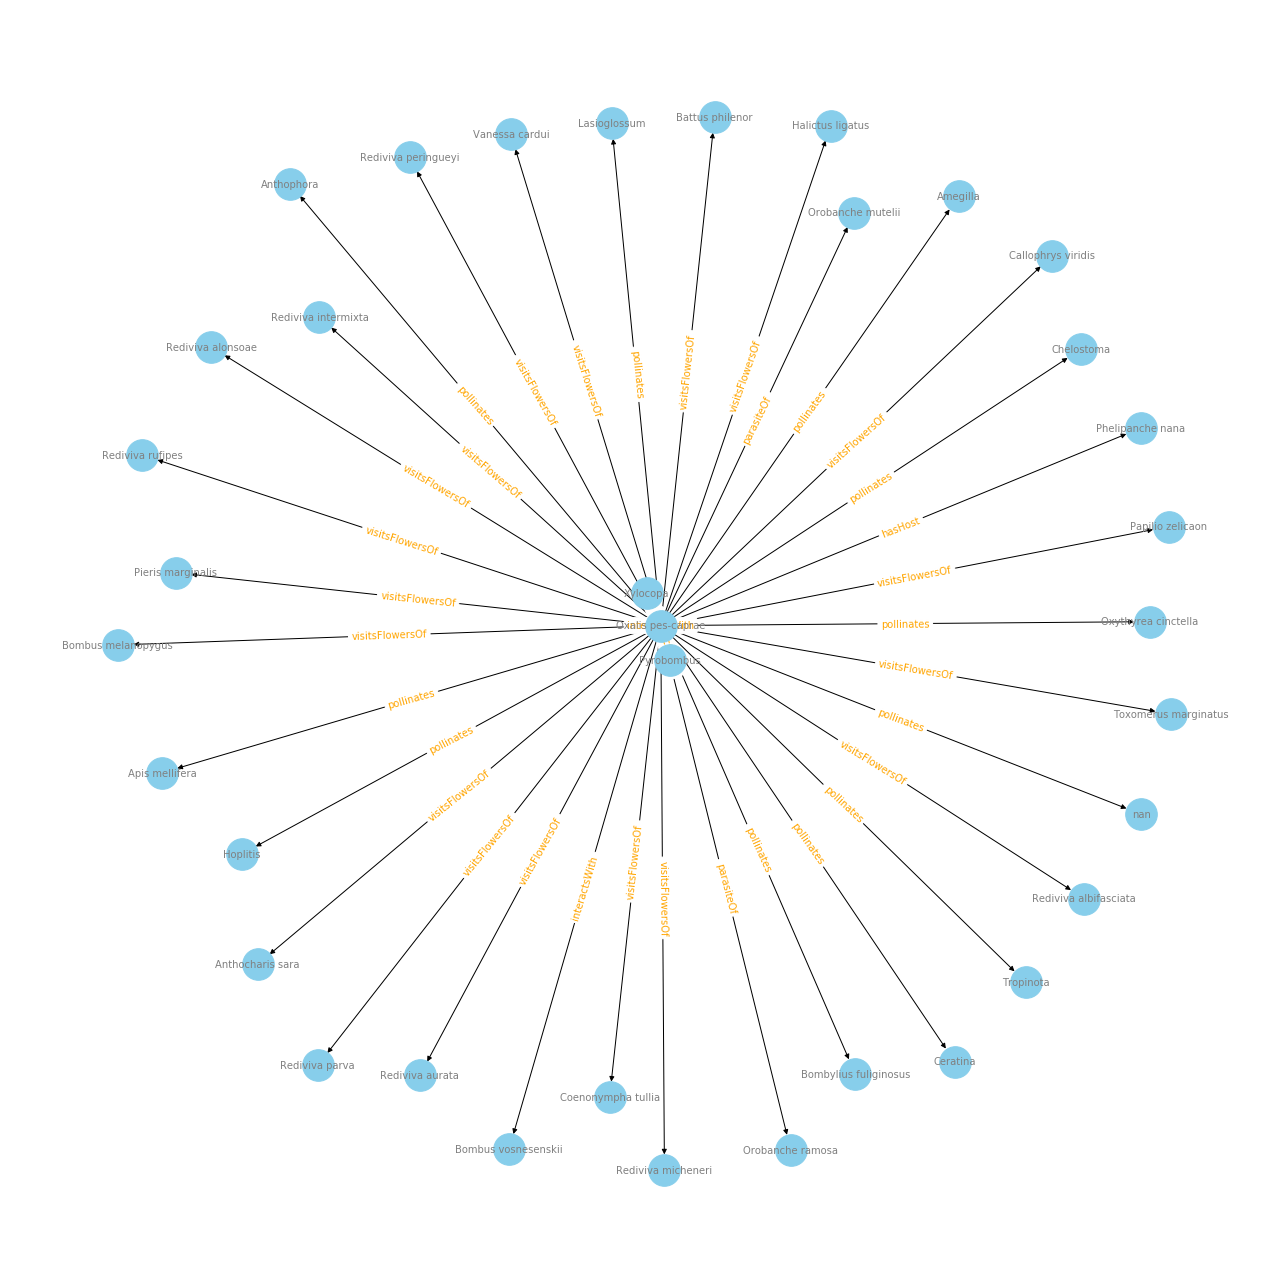

In [100]:
plt.figure(figsize=(18,18))
edge_labels = nx.get_edge_attributes(G,'label')

pos = nx.spring_layout(G) 
nx.draw_networkx_edge_labels(G,pos, edge_labels = edge_labels, font_size=10, font_color='orange')

nx.draw_networkx(G, pos, with_labels=True, node_size=1000, node_color="skyblue", alpha= 1, arrows=True, 
                    linewidths=1, font_color="grey", font_size=10, style = 'dashed')

plt.axis('off')
plt.tight_layout()
plt.show()